In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

In [2]:
loans = pd.read_csv('Task 3 and 4_Loan_Data.csv')

In [3]:
# check basic info
loans.info

<bound method DataFrame.info of       customer_id  credit_lines_outstanding  loan_amt_outstanding  \
0         8153374                         0           5221.545193   
1         7442532                         5           1958.928726   
2         2256073                         0           3363.009259   
3         4885975                         0           4766.648001   
4         4700614                         1           1345.827718   
...           ...                       ...                   ...   
9995      3972488                         0           3033.647103   
9996      6184073                         1           4146.239304   
9997      6694516                         2           3088.223727   
9998      3942961                         0           3288.901666   
9999      5533570                         1           1917.652480   

      total_debt_outstanding       income  years_employed  fico_score  default  
0                3915.471226  78039.38546               5 

In [4]:
# check basic info
loans.describe()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.974577e+06,1.461200,4159.677034,8718.916797,70039.901401,4.552800,637.557700,0.185100
std,2.293890e+06,1.743846,1421.399078,6627.164762,20072.214143,1.566862,60.657906,0.388398
min,1.000324e+06,0.000000,46.783973,31.652732,1000.000000,0.000000,408.000000,0.000000
25%,2.977661e+06,0.000000,3154.235371,4199.836020,56539.867903,3.000000,597.000000,0.000000
50%,4.989502e+06,1.000000,4052.377228,6732.407217,70085.826330,5.000000,638.000000,0.000000
75%,6.967210e+06,2.000000,5052.898103,11272.263740,83429.166133,6.000000,679.000000,0.000000
max,8.999789e+06,5.000000,10750.677810,43688.784100,148412.180500,10.000000,850.000000,1.000000


In [5]:
# check basic info
loans['default'].value_counts()

0    8149
1    1851
Name: default, dtype: int64

In [6]:
# check missing values
loans.isnull().sum()

customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64

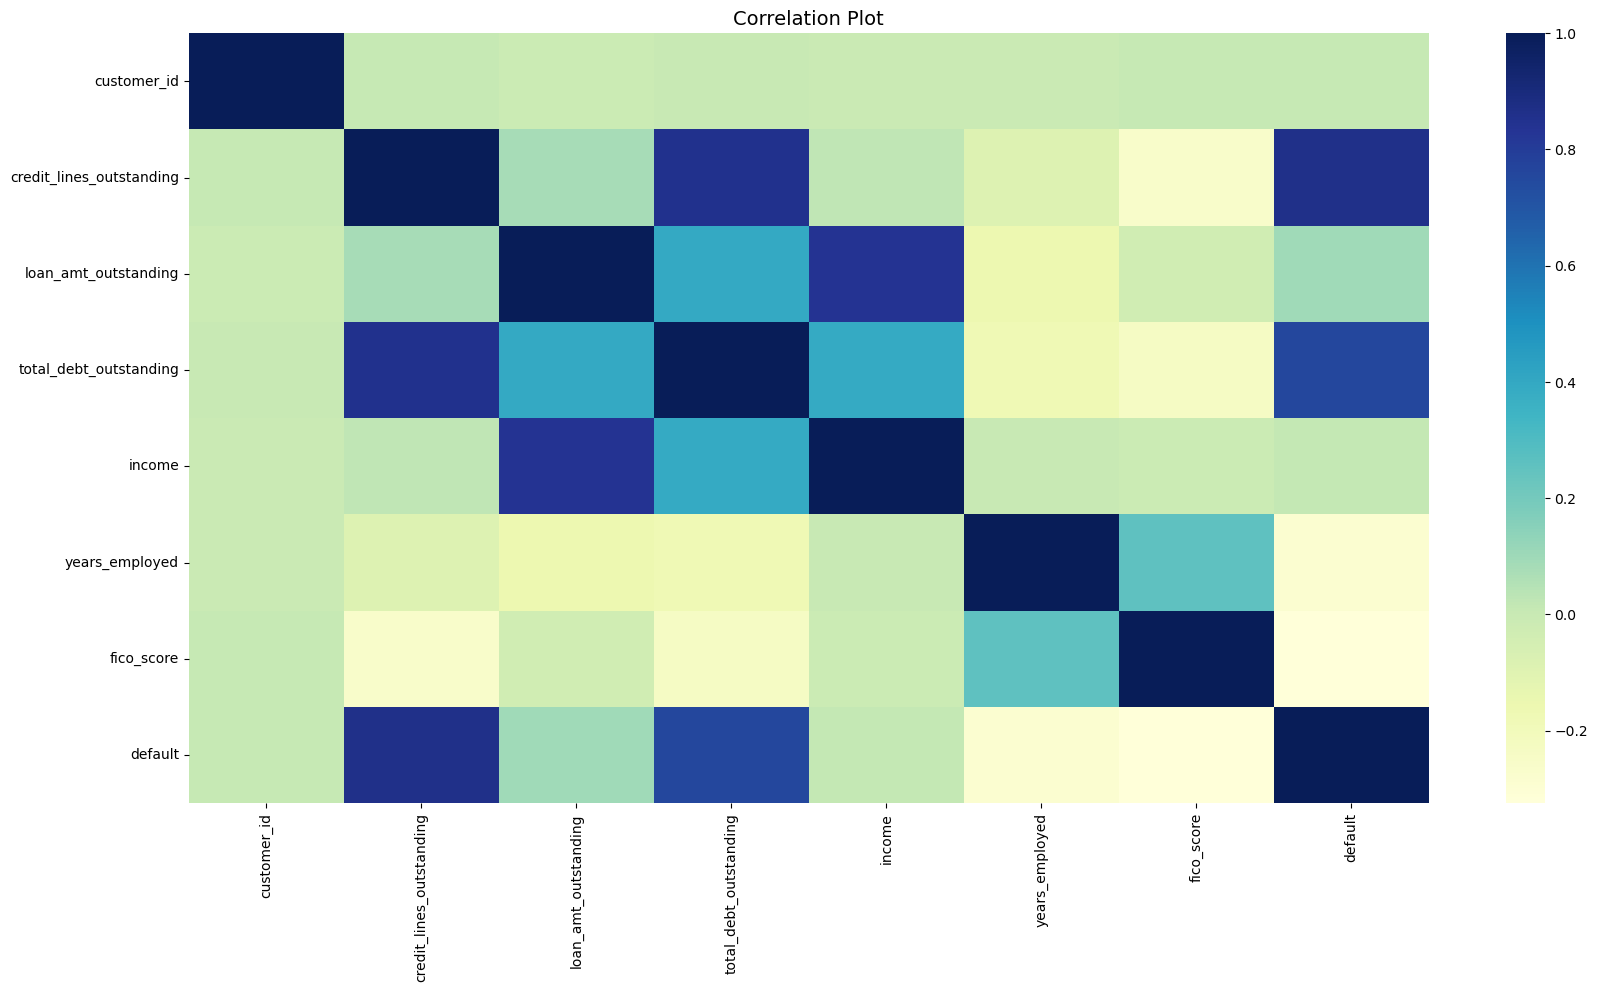

In [7]:
# check correlation
corr = loans.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size': 30})
plt.title("Correlation Plot", fontsize=14)
plt.show()

In [8]:
# decomposite into dependent and independent variables
X = loans.drop(columns=['customer_id', 'default'])
y = loans['default']

In [9]:
# standarization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
# set training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [11]:
# apply logistic model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [12]:
# predict on testing data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [13]:
# evaluate the prediction
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred_proba))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1652
           1       1.00      0.98      0.99       348

    accuracy                           1.00      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000

0.9999686899891458


In [14]:
# AUC is high, move to formal prediction
def prob(new_borrower, recovery_rate):
    new_borrower_scaled = scaler.transform(new_borrower)
    new_borrower_scaled.reshape(1,-1)
    default_probability = model.predict_proba(new_borrower_scaled)[:, 1]
    print("Default Probability for the new borrower:", default_probability[0])
    loss = default_probability * (1 - recovery_rate) * new_borrower[0][2]
    print("Expected Loss from the new borrower:", loss)

In [15]:
# an example
new_borrower = np.array([[0, 5000, 3000, 80000, 5, 700]]) 
prob(new_borrower, 0.1)

Default Probability for the new borrower: 1.3018257329061445e-12
Expected Loss from the new borrower: [3.51492948e-09]


/Users/zhuzixuan/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [19]:
# we can also apply XG-Boost, apply the same steps with this model
model2 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
y_pred_proba2 = model2.predict_proba(X_test)[:, 1]
print("Accuracy:", accuracy_score(y_test, y_pred2))
print(classification_report(y_test, y_pred2))
AUC = roc_auc_score(y_test, y_pred_proba2)
print("ROC AUC:", AUC)

Accuracy: 0.9945
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1652
           1       0.99      0.98      0.98       348

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

ROC AUC: 0.9998521471709665


/Users/zhuzixuan/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [01:08:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [20]:
# AUC is high, move to formal prediction (but logistic regression has higher AUC)
def prob(new_borrower, recovery_rate):
    new_borrower_scaled = scaler.transform(new_borrower)
    new_borrower_scaled.reshape(1,-1)
    default_probability = model2.predict_proba(new_borrower_scaled)[:, 1]
    print("Default Probability for the new borrower:", default_probability[0])
    loss = default_probability * (1 - recovery_rate) * new_borrower[0][2]
    print("Expected Loss from the new borrower:", loss)

In [21]:
# an example
new_borrower = np.array([[0, 5000, 3000, 80000, 5, 700]]) 
prob(new_borrower, 0.1)

Default Probability for the new borrower: 1.6392142e-06
Expected Loss from the new borrower: [0.00442588]


/Users/zhuzixuan/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
